**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there is one small problem that needs to be fixed before the project is accepted. Let me know if you have any questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### import libraries

In [1]:
%%time
# update libraries
!pip install pandas -U
!pip install scikit-learn -U
!pip install catboost -U
!pip install lightgbm -U
!pip install xgboost -U

     |████████████████████████████████| 11.7 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
     |████████████████████████████████| 30.8 MB 124 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 76.6 MB 54 kB/s s eta 0:00:01
  Attempting uninstall: catboost
    Found existing installation: catboost 1.0.3
    Uninstalling catboost-1.0.3:
      Successfully uninstalled catboost-1.0.3
     |████████████████████████████████| 2.0 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.1
    Uninstalling lightgbm-3.3.1:
      Successfully uninstalled lightgbm-3.3.1
     |████████████████████████████████| 192.9 MB 27 kB/s /s eta 0:00:01 |

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import catboost


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# definitions
pd.options.display.float_format = '{:,.2f}'.format
state = np.random.RandomState(12345)
matplotlib.rc('figure', figsize=(10, 8),dpi=200)
plt.rcParams["font.size"] = 8

In [3]:
# delete error messages
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Open the data file and study the general information.

In [4]:
# read input data
try:
    df = pd.read_csv("taxi.csv", sep=",",index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv("/datasets/taxi.csv", sep=",",index_col=[0], parse_dates=[0])
df.name='taxi data'

In [5]:
# show the data
print('************************')
print(df.name)
print('************************')
display(df.info())
display(df.head())

************************
taxi data
************************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.shape

(26496, 1)

**conclusion:**

- The dataframe has 26,496 observation (rows)
- The dataframe has 1 column
- The index is date time with 10 minutes between every row

## Analysis

### Resample the data to 1 hour

In [7]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you made sure that the data is correctly sorted and resampled it

</div>

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


### Analyze the data

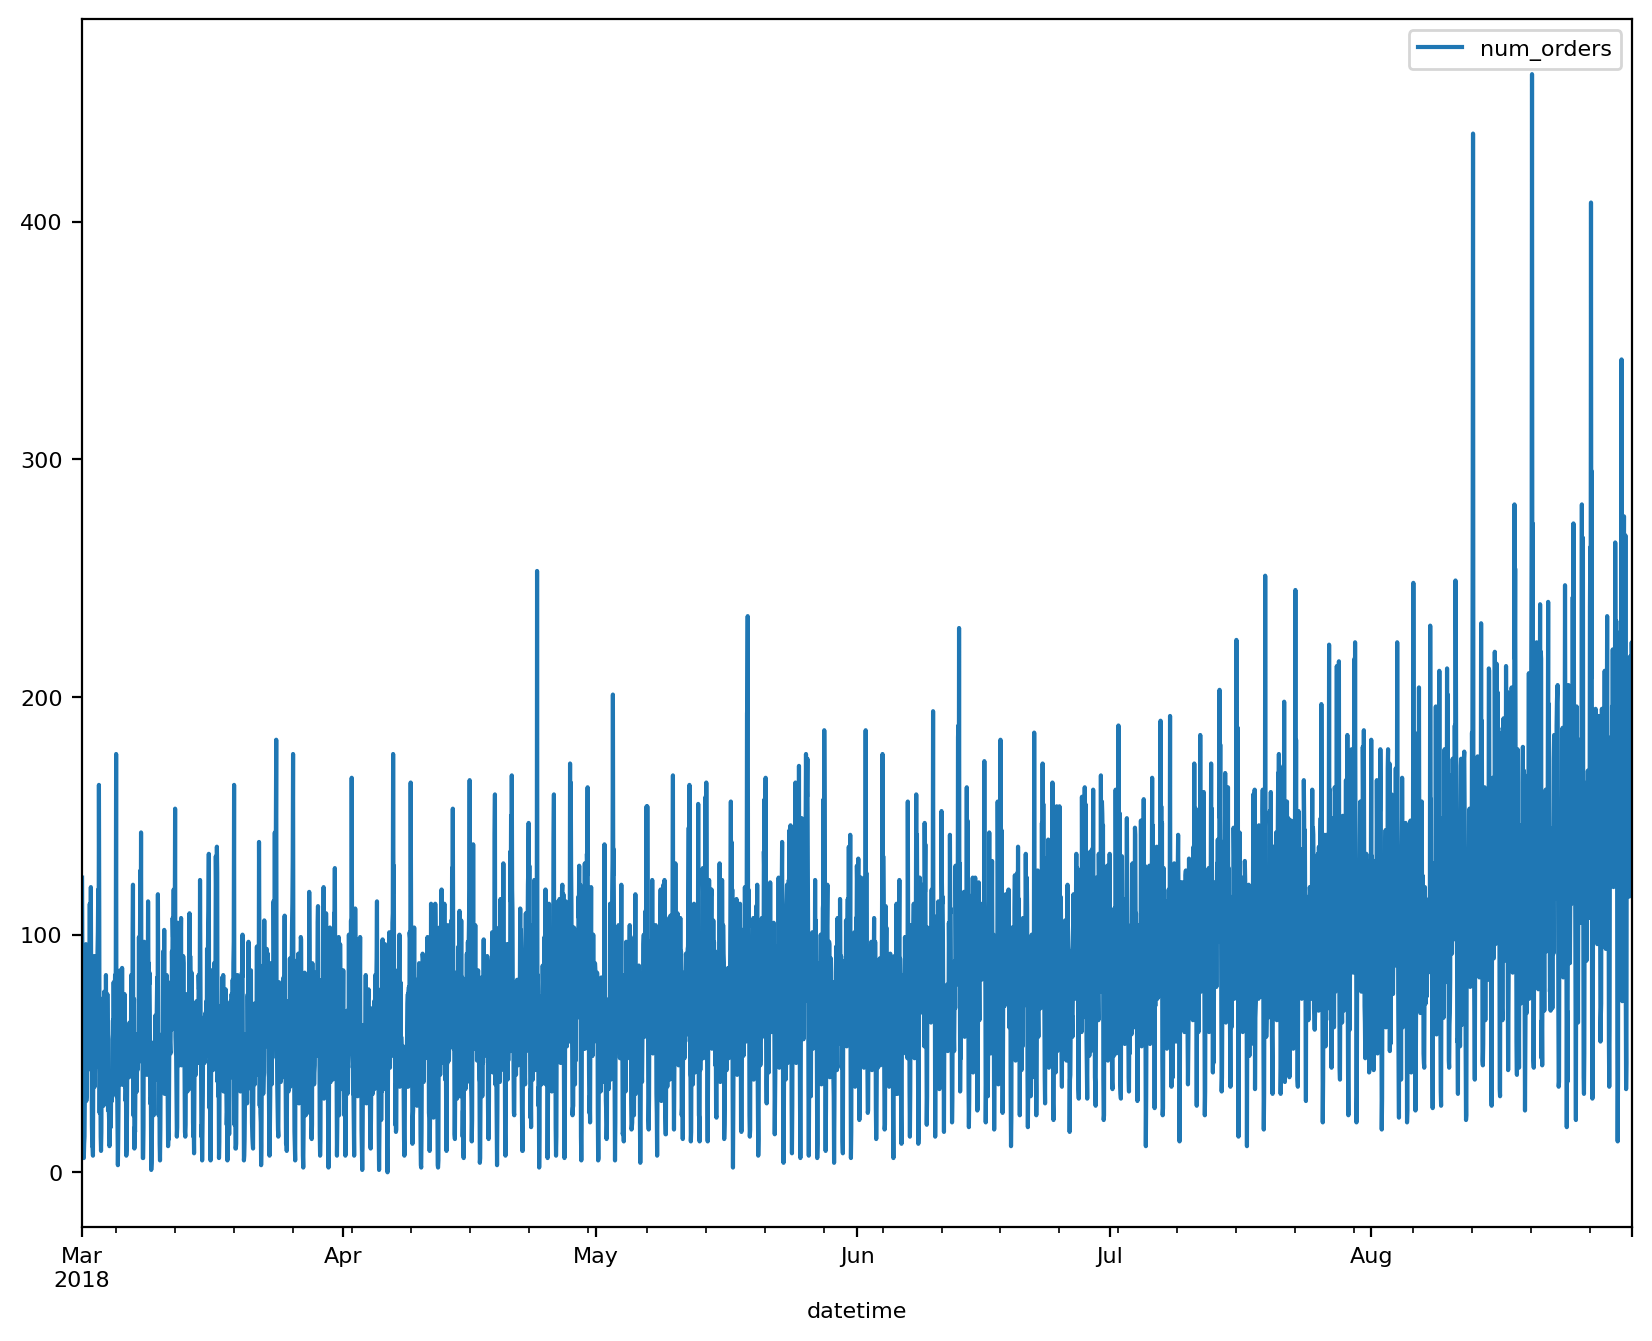

In [10]:
df.plot();

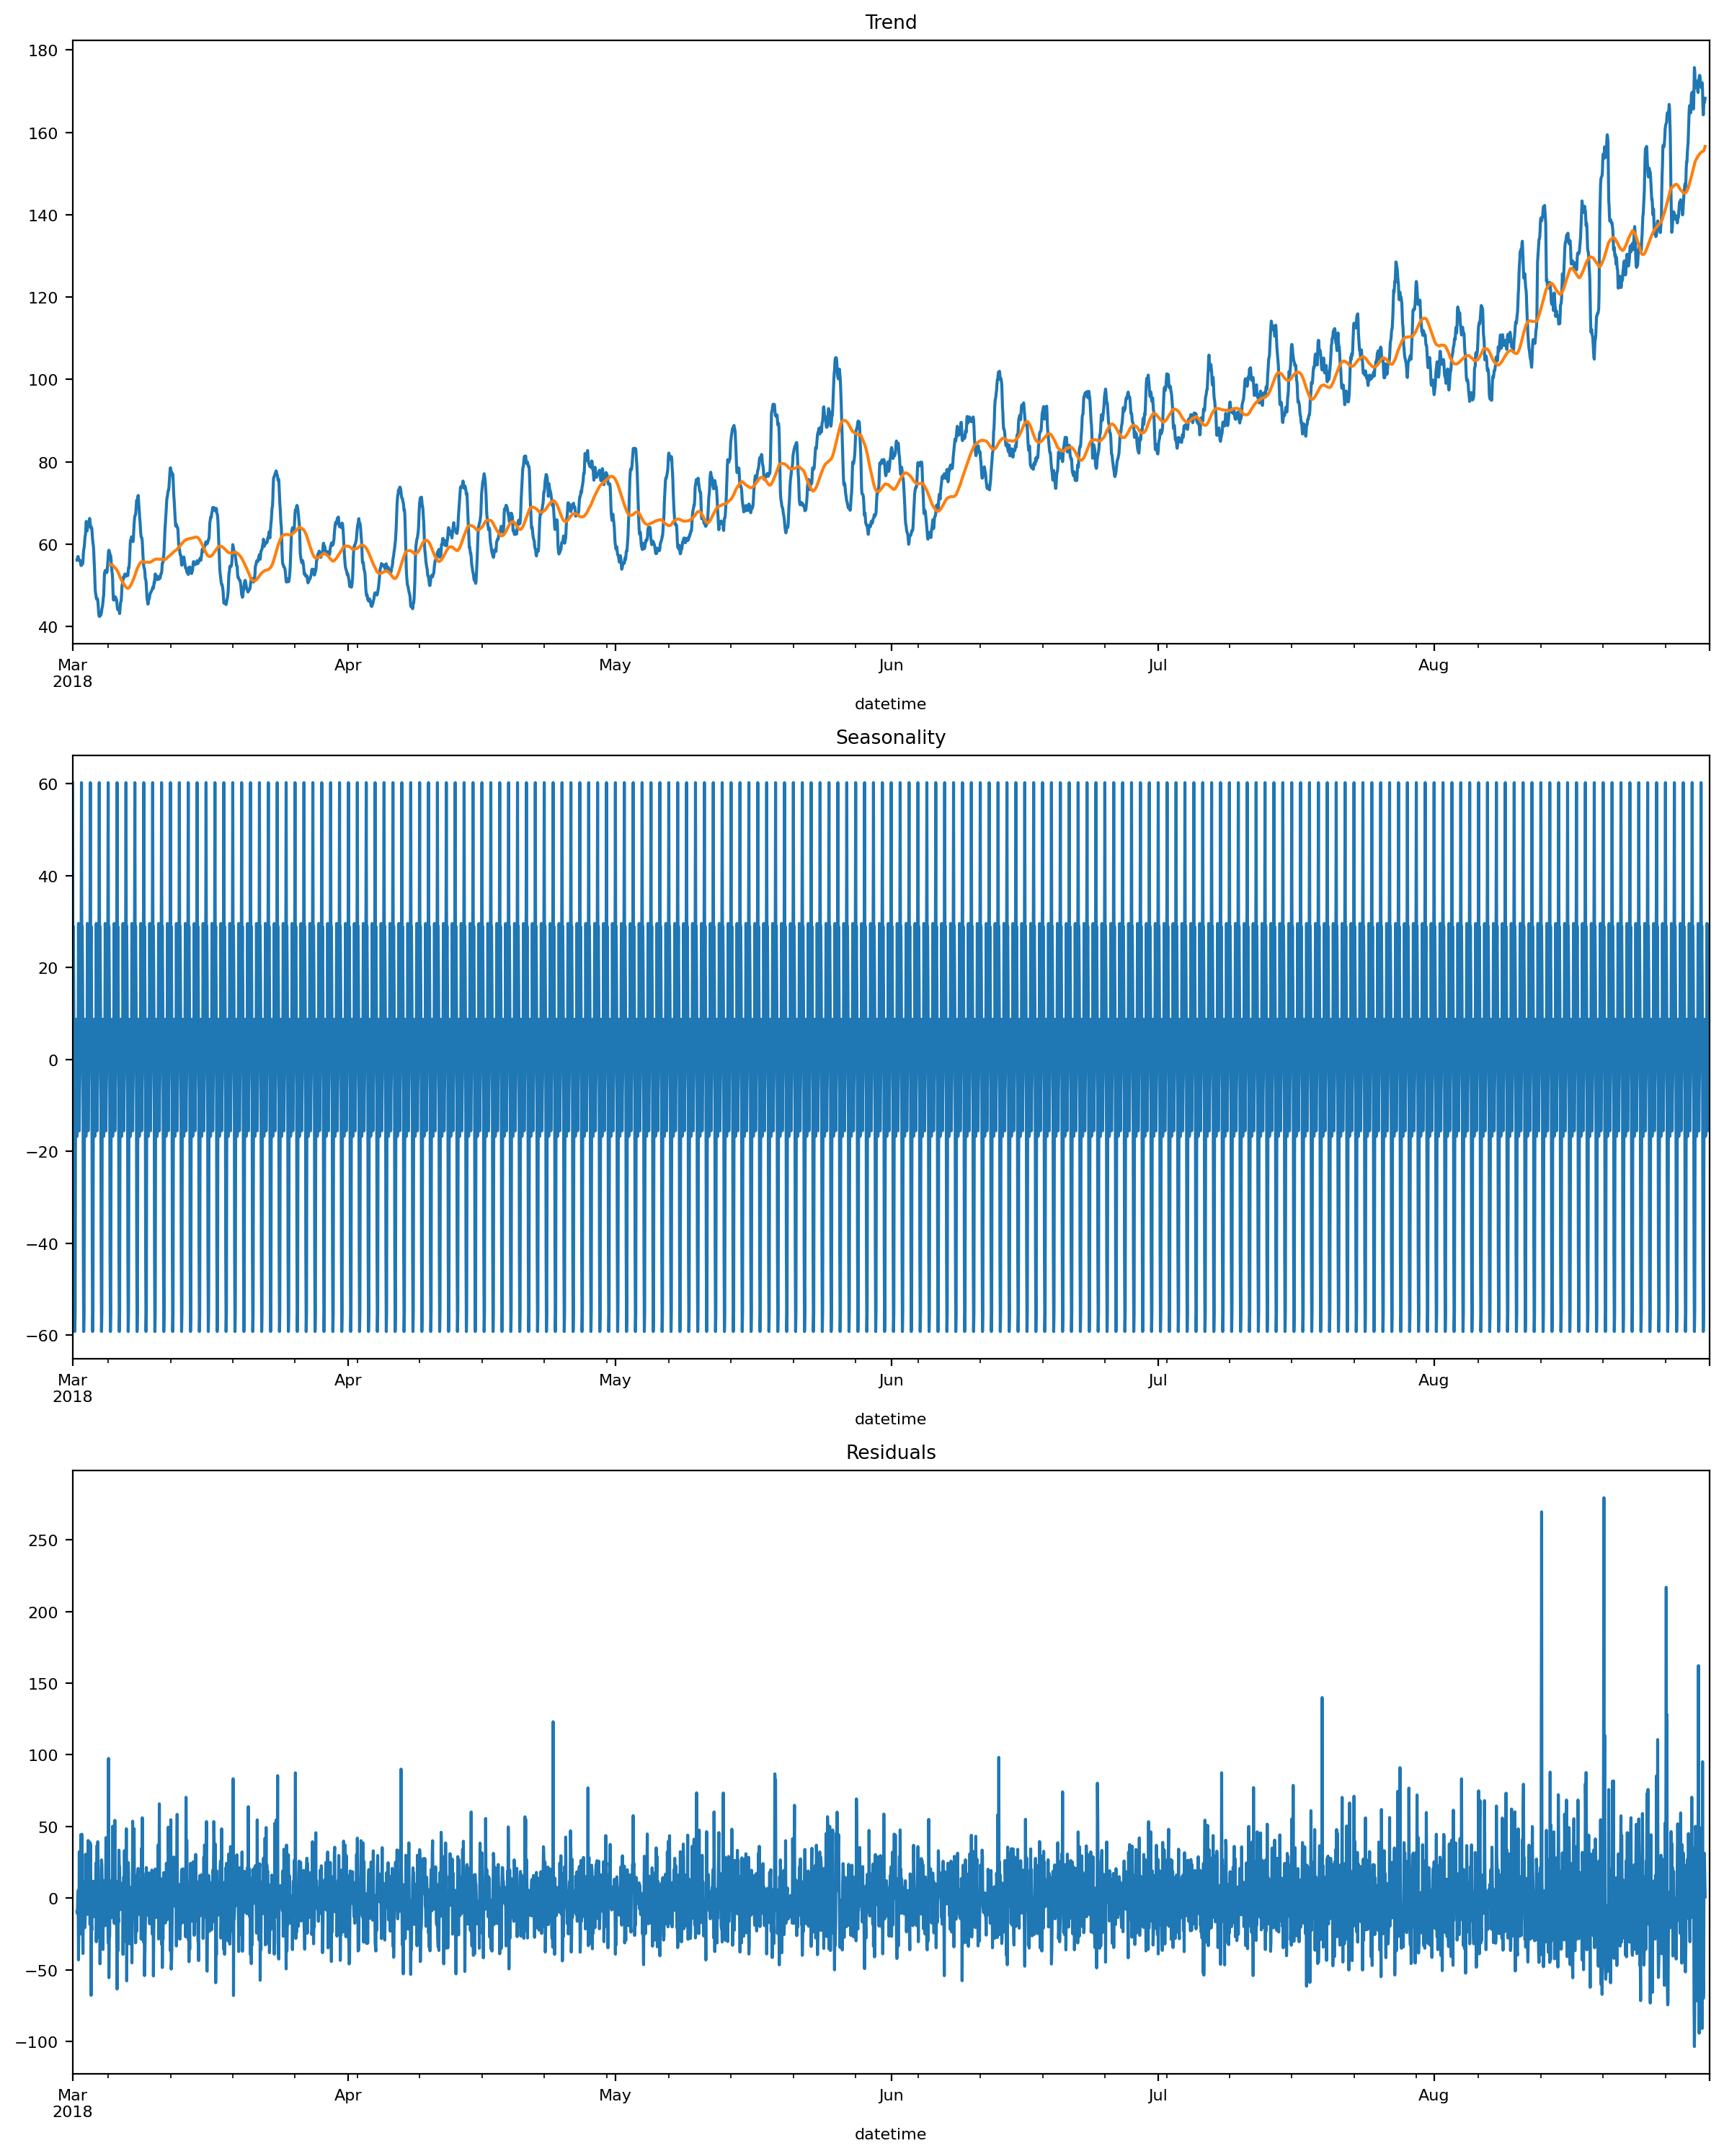

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.rolling(90).mean().plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**conclusion:** for the full period from March 2018 to August 2018 we can see that:

- The trend is usually up
- There is Seasonality but we need to examine it in smaller window
- the Residuals (noise) is the same for all the period except some daily Fluctuations.

### with daily data  

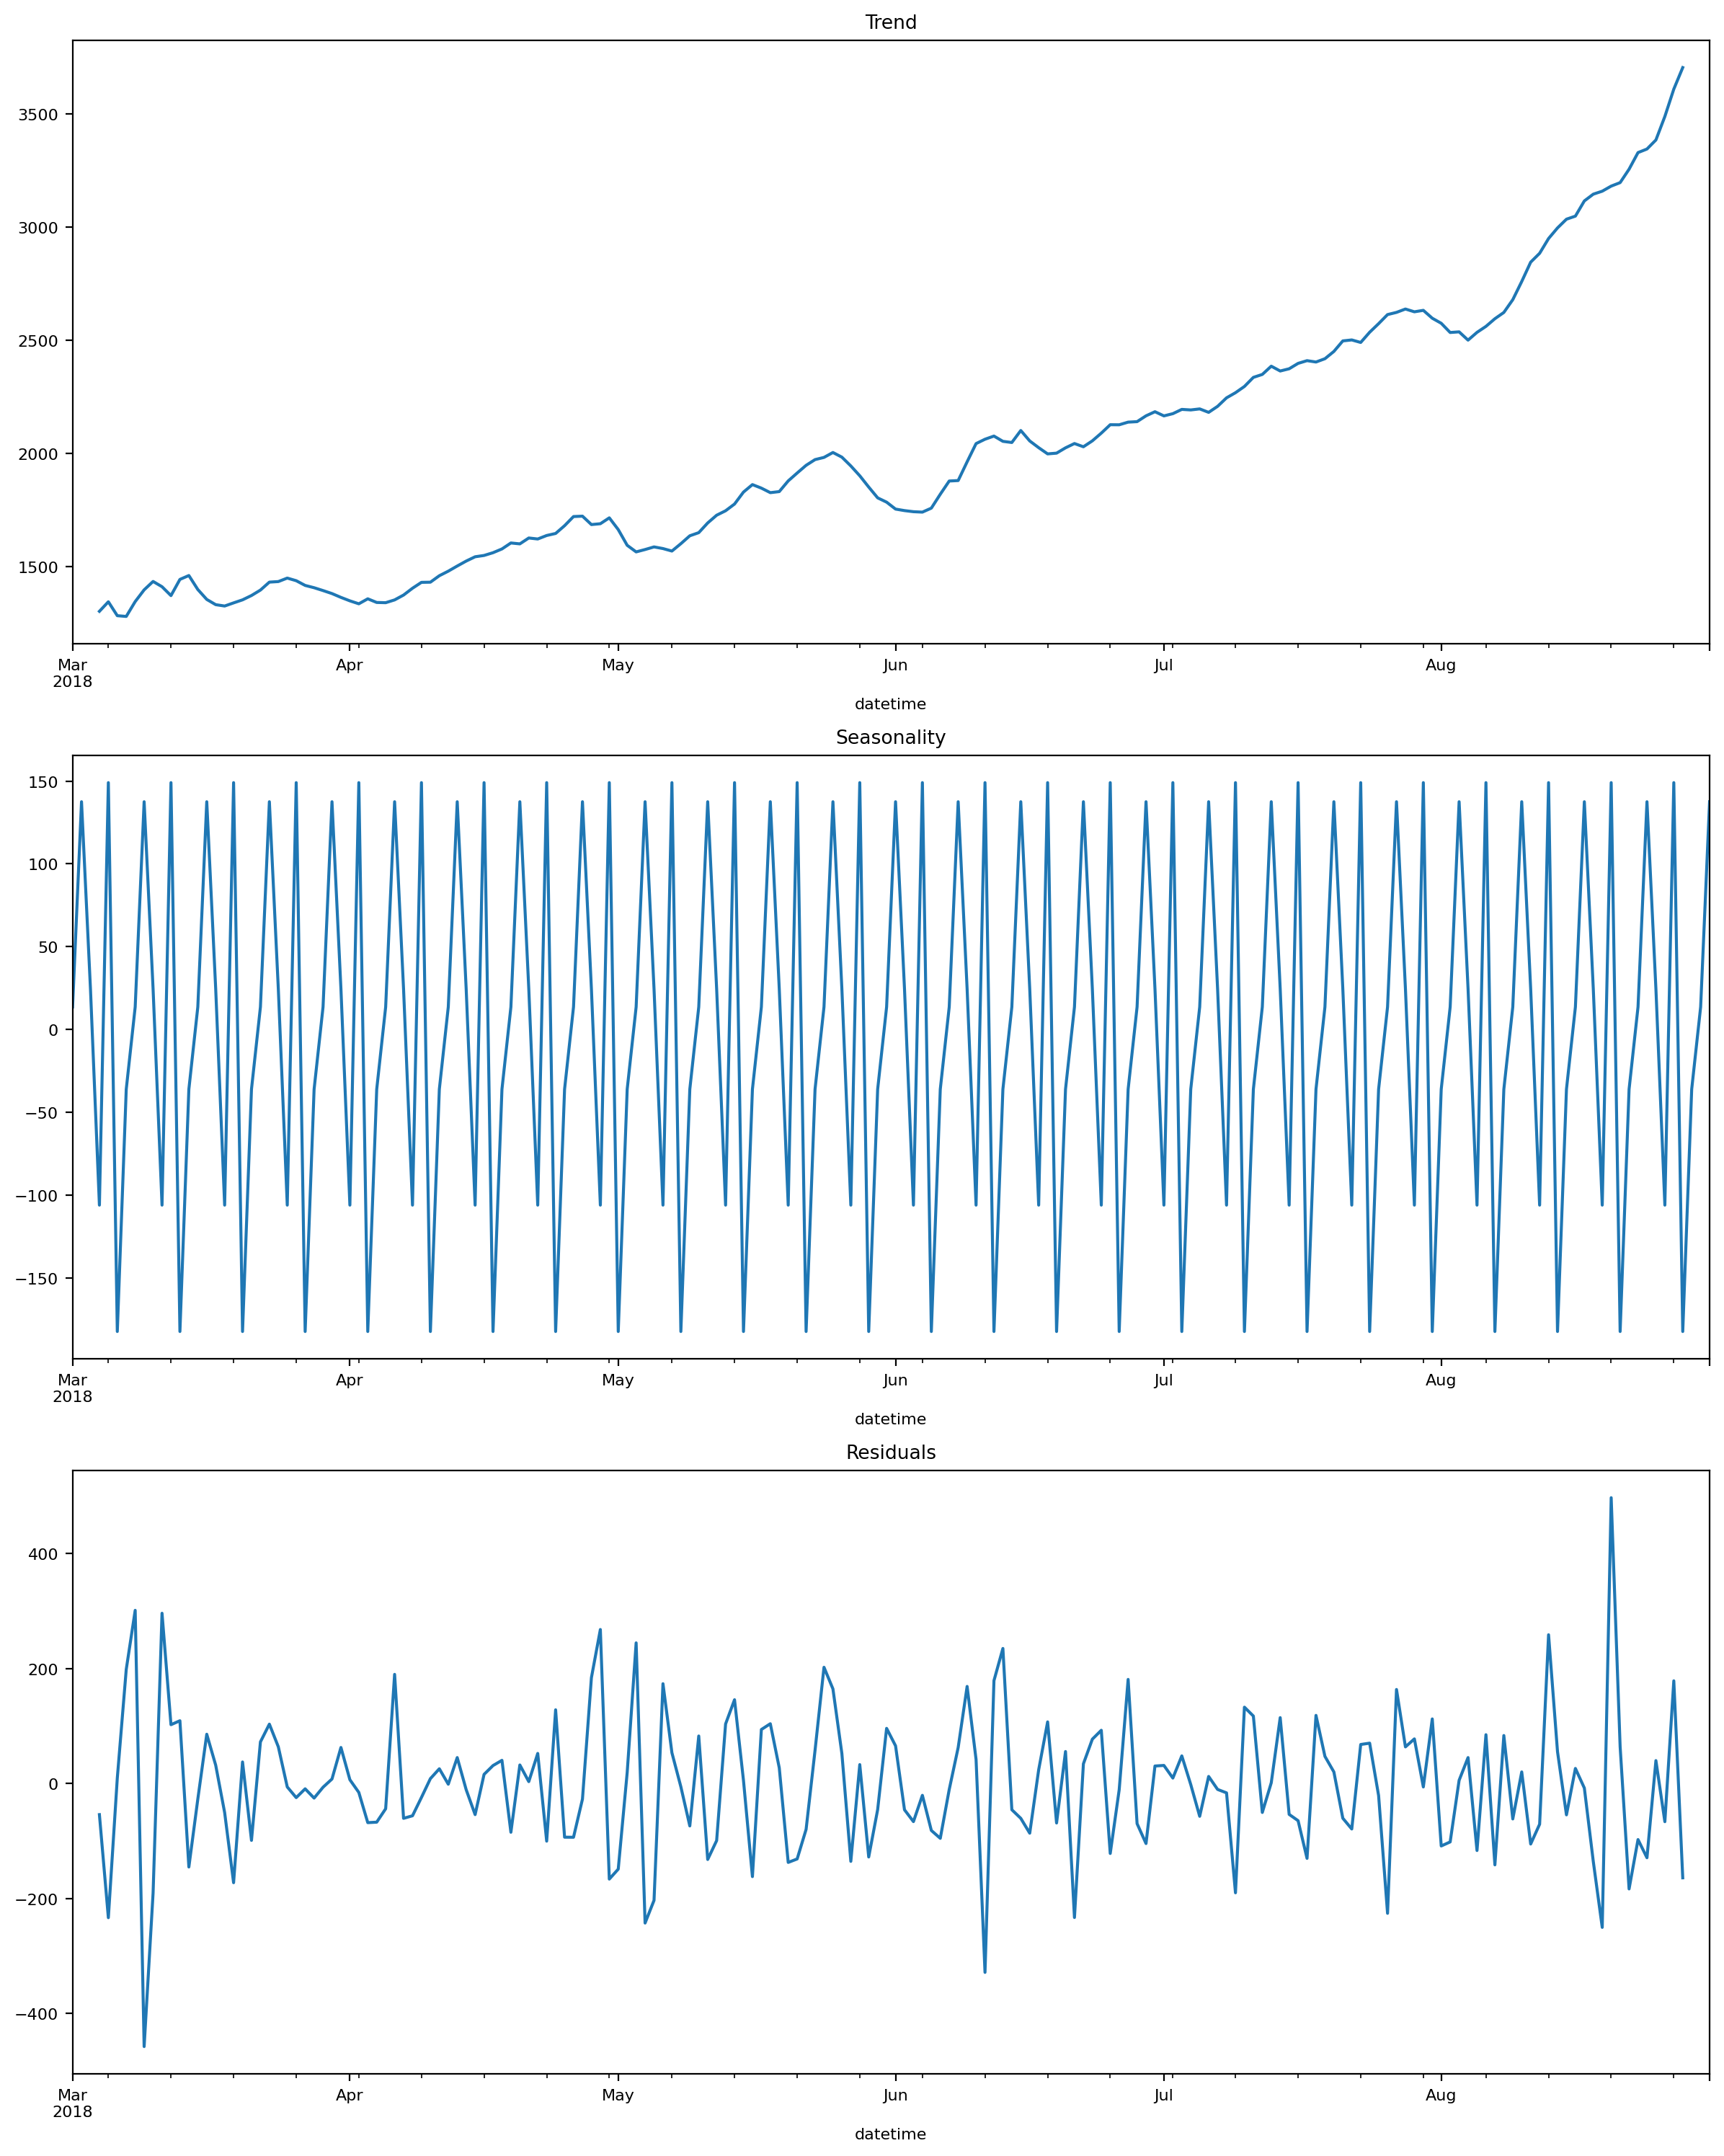

In [12]:
decomposed = seasonal_decompose(df['num_orders'].resample('1D').sum())

plt.figure(figsize=(12, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**conclusion:** for the full period from March 2018 to August 2018 with daily data, we can see that:

- The trend is up
- There is a clear Seasonality

### Looking at one weeks

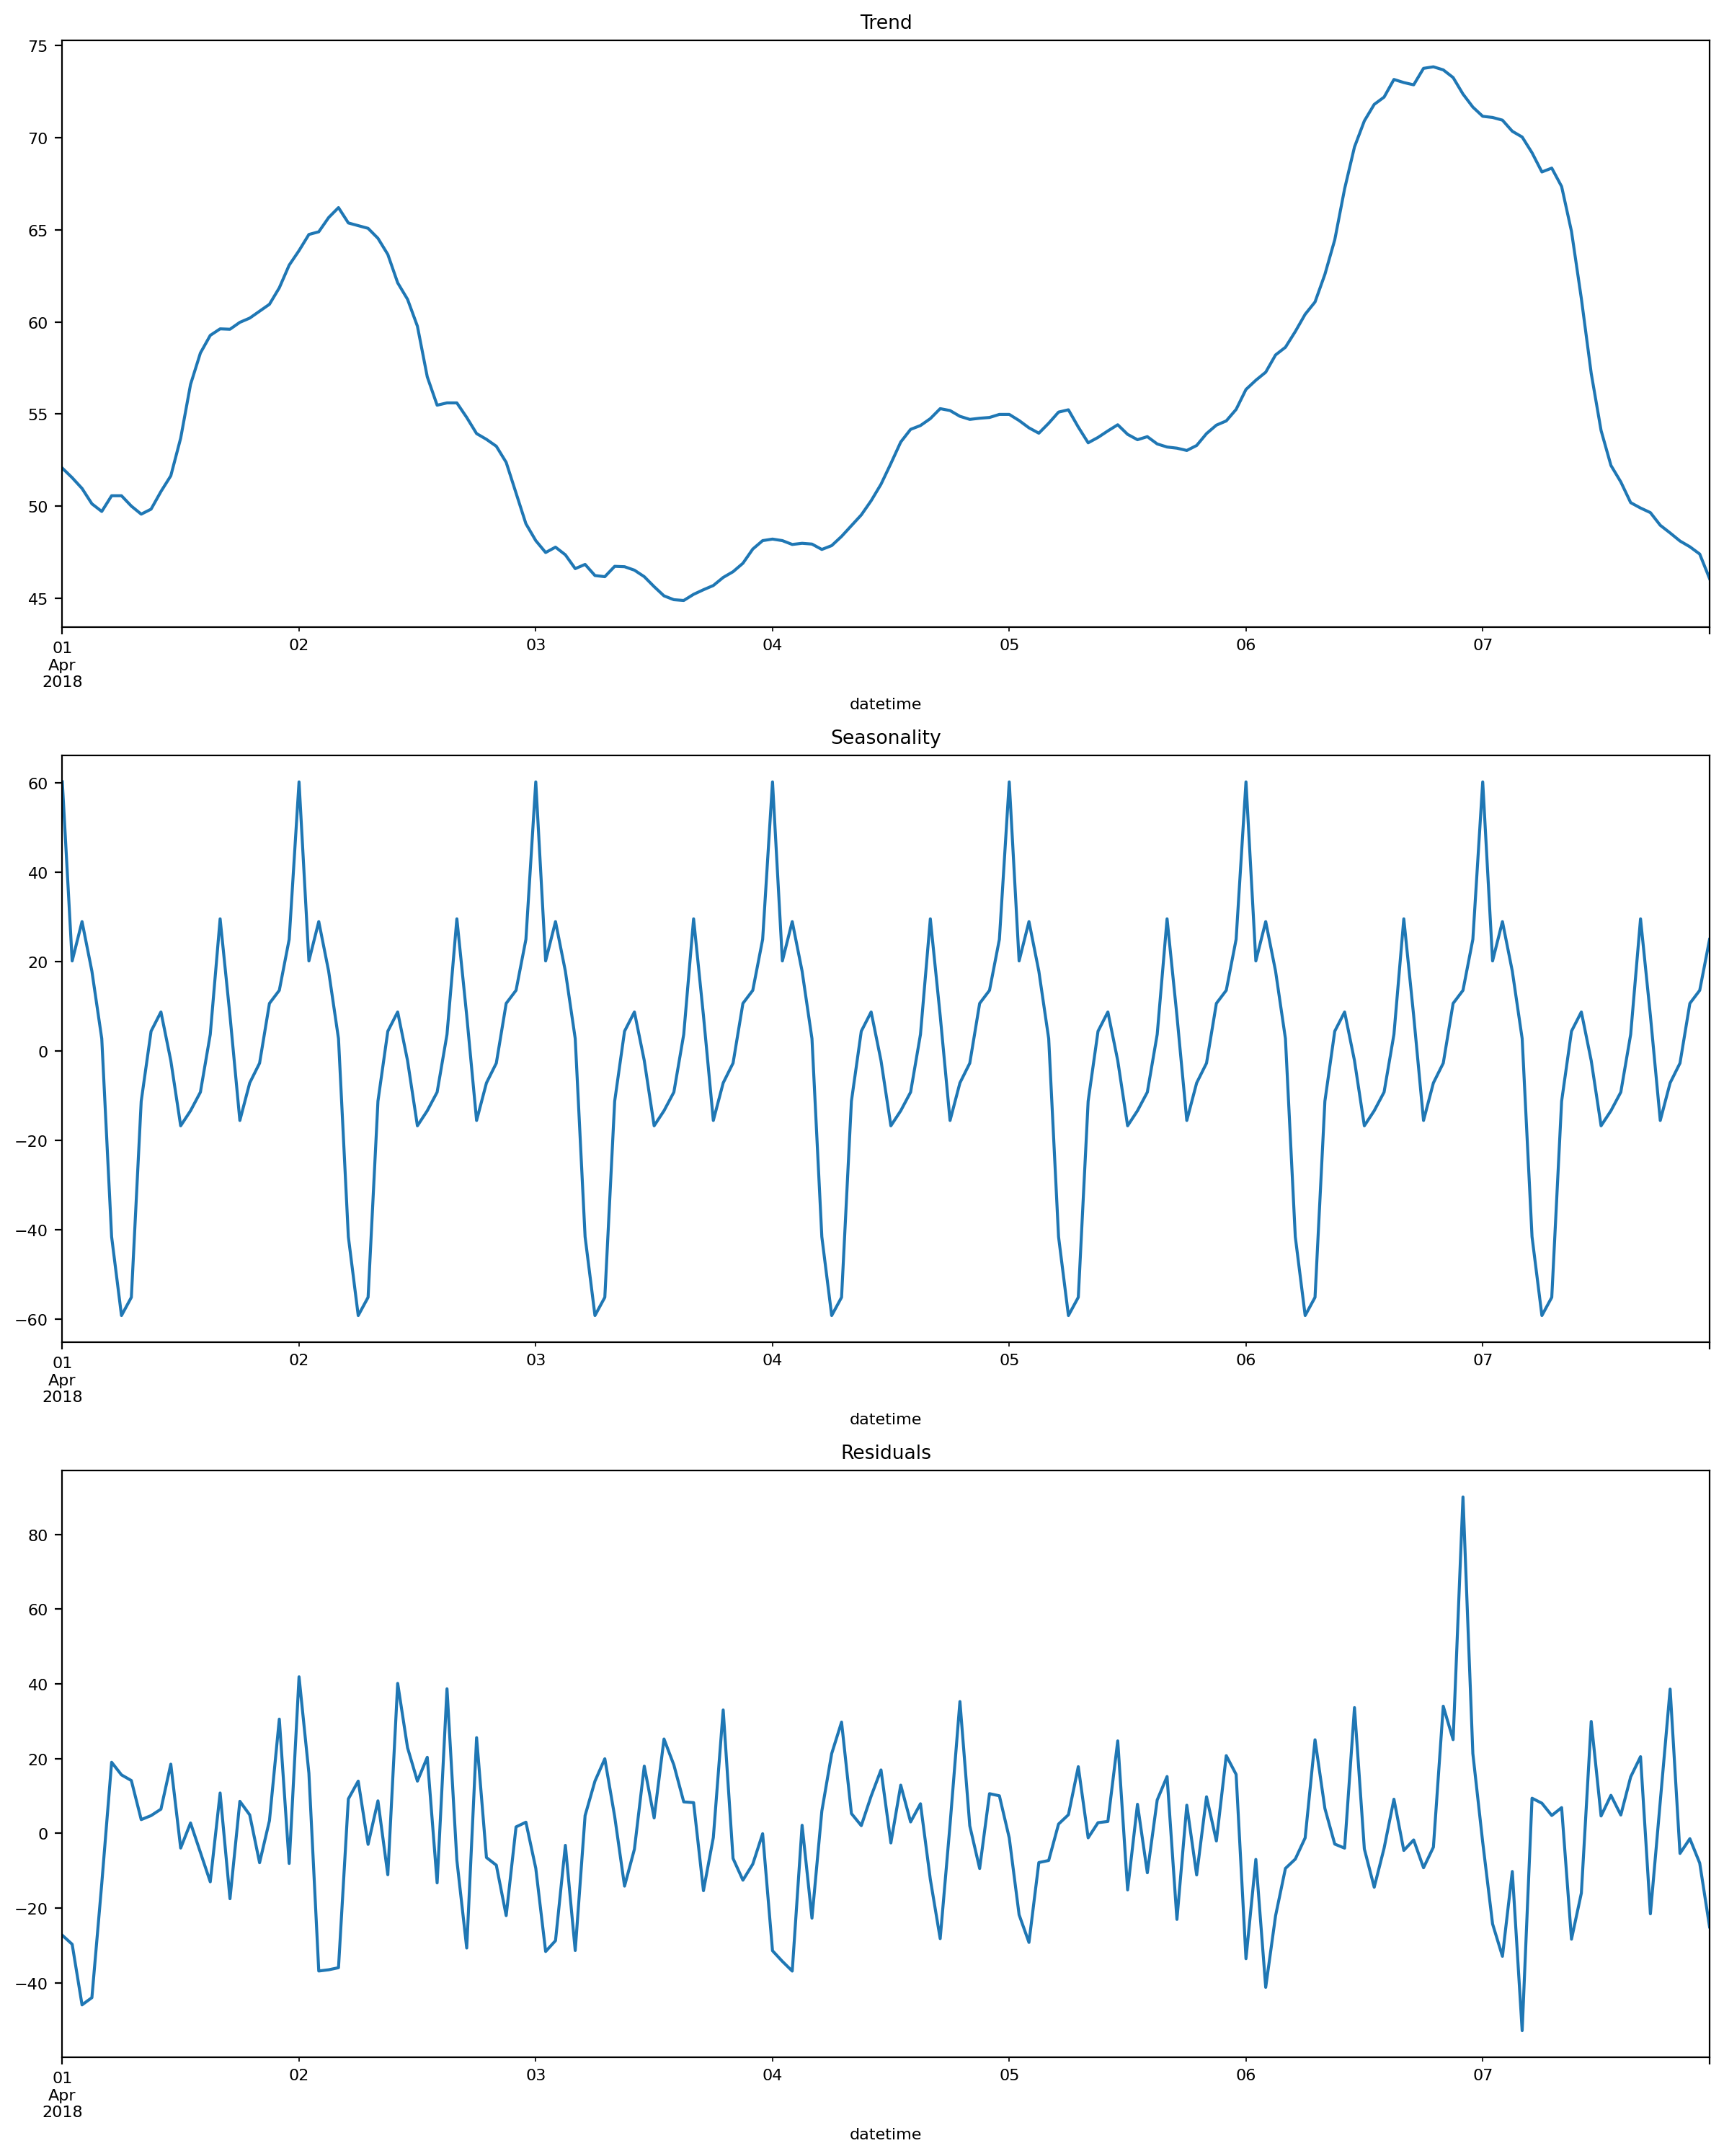

In [13]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 15))

plt.subplot(311)
decomposed.trend['2018-04-01':'2018-04-07'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-04-01':'2018-04-07'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**conclusion:** In one week window with hourly data, we can see clearly the Seasonality with cycle of 24 hours. The trend is not clear at all.

### Looking at standard deviation and average

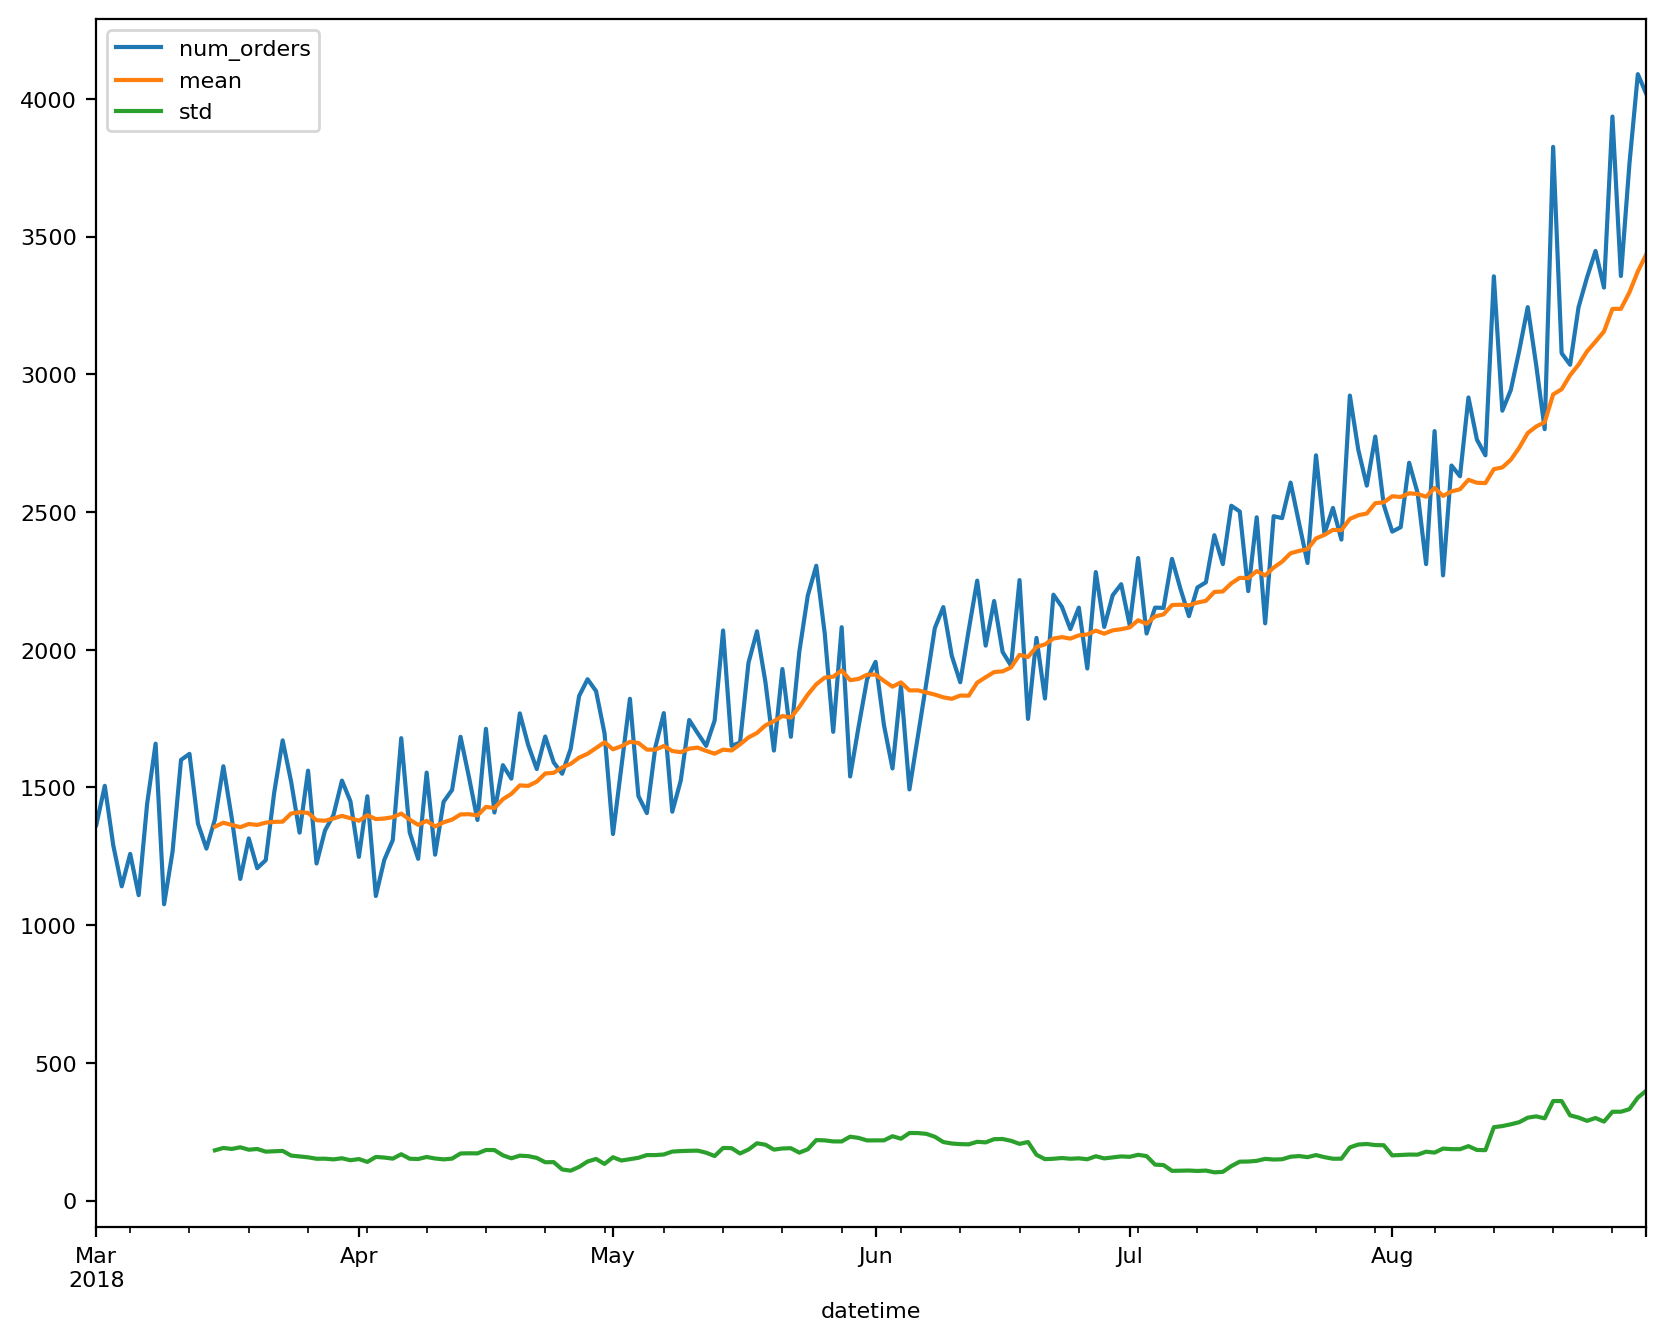

In [14]:
df1=df.copy()
df1 = df1.resample('1D').sum()
df1['mean'] = df1['num_orders'].rolling(15).mean()
df1['std'] = df1['num_orders'].rolling(15).std()
df1.plot();

**conclusion:** The std is not change over time but the average is raising. We can say that the data is nonstationary time series.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, you visualized the data, did a seasonal decomposition and noted some interesting patterns

</div>

## Training

### Making features


In [15]:
df_back=df.copy()

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean']=data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 4, 6)
df.head(7)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.00,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.00,124.00,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.00,85.00,124.00,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.00,71.00,85.00,124.00,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.00,66.00,71.00,85.00,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.00,43.00,66.00,71.00,65.83


<div class="alert alert-success">
<b>Reviewer's comment</b>

Feature engineering looks good: there are calendar features, lag features and a correctly shifted rolling mean

</div>

###  Separate train and test


In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train_features=train.drop(['num_orders'],axis=1)
train_target=train['num_orders']
test_features=test.drop(['num_orders'],axis=1)
test_target=test['num_orders']


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test without shuffling

</div>

## Testing

- RMSE - Root Mean Square Error - how the data is concentrated around the line of best fit. Expected to be as lower as possible. (absolute value in the same units of measurement as our target)
- The RMSE metric on the test set should not be more than 48.

### Linear regression

In [18]:
model_lr=LinearRegression()
model_lr.fit(train_features,train_target)
train_pred=model_lr.predict(train_features)
test_pred=model_lr.predict(test_features)

print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')

print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

RMSE for the training set: 30.475
RMSE for the test set: 52.971


**conclusion:** the base model RMSE is above the max demand of the project.

### Cross validation of time series data

We tried to run the model in cross validation. Because it is time series, it cannot be random selected, classical cross-validation techniques assume the samples are independent and identically distributed, but time series data is characterized by the correlation between observations that are near in time. Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model

<div class="alert alert-success">
<b>Reviewer's comment</b>

You are absolutely right!

</div>

In [19]:
X = train_features
y = train_target

tscv = TimeSeriesSplit(n_splits=7)

In [20]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_lr.fit(X_train,y_train)
    train_pred=model_lr.predict(X_train)
    test_pred=model_lr.predict(X_test)
    print('-'*50)
    print('size of train:', X_train.shape[0])
    print(f'RMSE for the training set:\t {(mean_squared_error(y_train,train_pred)**0.5):.3f}')
    print(f'RMSE for the test set:\t\t {(mean_squared_error(y_test,test_pred)**0.5):.3f}\n')

--------------------------------------------------
size of train: 496
RMSE for the training set:	 23.658
RMSE for the test set:		 25.479

--------------------------------------------------
size of train: 992
RMSE for the training set:	 24.390
RMSE for the test set:		 29.219

--------------------------------------------------
size of train: 1488
RMSE for the training set:	 25.926
RMSE for the test set:		 28.829

--------------------------------------------------
size of train: 1984
RMSE for the training set:	 26.653
RMSE for the test set:		 29.615

--------------------------------------------------
size of train: 2480
RMSE for the training set:	 27.242
RMSE for the test set:		 31.589

--------------------------------------------------
size of train: 2976
RMSE for the training set:	 27.977
RMSE for the test set:		 34.343

--------------------------------------------------
size of train: 3472
RMSE for the training set:	 28.924
RMSE for the test set:		 39.902



**conclusion:**
as the size of the train grows, the RMSE grows too. It is unacceptable, so we would not use this method and will try manually to improve the hyperpameters of the models.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Not sure what you mean by 'manually'. I hope that doesn't mean using the test set to tune hyperparameters, as that is a way worse problem: then our test set scores become biased, and no longer tell us anything about how well the model generalizes to new data

</div>

## XGBoost

In [21]:
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100,learning_rate=0.01, random_state=12345)
model_xgb.fit(train_features, train_target)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, ...)

In [22]:
train_pred = model_xgb.predict(train_features)
test_pred = model_xgb.predict(test_features)

In [23]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')

print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

RMSE for the training set: 38.699
RMSE for the test set: 86.005


**conclusion:** the default hyperparameters of XGBoost returns RMSE above 48. We will try to improve it.

### Hyperparameters

In [24]:
pipe = Pipeline(steps=[('sc',StandardScaler()),('xgb',XGBRegressor(objective='reg:squarederror', random_state=12345))])

In [25]:
tscv = TimeSeriesSplit(n_splits=7)

In [26]:
gridsearch = GridSearchCV(estimator=pipe, cv=tscv,
                        param_grid={'xgb__n_estimators':[100, 250,500],'xgb__learning_rate':[0.01,0.03,0.05 ,0.1, 0.8]})

In [27]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sc', 'xgb', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'xgb__objective', 'xgb__base_score', 'xgb__booster', 'xgb__callbacks', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__early_stopping_rounds', 'xgb__enable_categorical', 'xgb__eval_metric', 'xgb__gamma', 'xgb__gpu_id', 'xgb__grow_policy', 'xgb__importance_type', 'xgb__interaction_constraints', 'xgb__learning_rate', 'xgb__max_bin', 'xgb__max_cat_to_onehot', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__max_leaves', 'xgb__min_child_weight', 'xgb__missing', 'xgb__monotone_constraints', 'xgb__n_estimators', 'xgb__n_jobs', 'xgb__num_parallel_tree', 'xgb__predictor', 'xgb__random_state', 'xgb__reg_alpha', 'xgb__reg_lambda', 'xgb__sampling_method', 'xgb__scale_pos_weight', 'xgb__subsample', 'xgb__tree_method', 'xgb__validate_parameters', 'xgb__verbosity'])

In [28]:
%%time
gridsearch.fit(train_features, train_target)

CPU times: user 2min 7s, sys: 1.8 s, total: 2min 9s
Wall time: 2min 9s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=12345,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.8],
                         'xgb__n_estimators': [100, 250, 500]})

In [29]:
train_pred = gridsearch.predict(train_features)
test_pred = gridsearch.predict(test_features)
rmse_train= mean_squared_error(train_target,train_pred)**0.5
rmse_test= mean_squared_error(test_target,test_pred)**0.5

In [30]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')
print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

RMSE for the training set: 14.506
RMSE for the test set: 47.010


**conclusion:** after manually tried to maximize the results, the RMSE is 47.01 and below 48.

### LightGBM

In [31]:
model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(train_features, train_target)

LGBMRegressor()

In [32]:
train_pred = model_lgbm.predict(train_features)
test_pred = model_lgbm.predict(test_features)

In [33]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')

print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

RMSE for the training set: 15.016
RMSE for the test set: 44.258


conclusion: the default hyperparameters of LightGBM returns RMSE below 48 as required. But, we will try to improve it.

### Hyperparameters

In [34]:

pipe = Pipeline(steps= [ ('sc',StandardScaler()),('lgbm',lgb.LGBMRegressor())])

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

In [36]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'sc', 'lgbm', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'lgbm__boosting_type', 'lgbm__class_weight', 'lgbm__colsample_bytree', 'lgbm__importance_type', 'lgbm__learning_rate', 'lgbm__max_depth', 'lgbm__min_child_samples', 'lgbm__min_child_weight', 'lgbm__min_split_gain', 'lgbm__n_estimators', 'lgbm__n_jobs', 'lgbm__num_leaves', 'lgbm__objective', 'lgbm__random_state', 'lgbm__reg_alpha', 'lgbm__reg_lambda', 'lgbm__silent', 'lgbm__subsample', 'lgbm__subsample_for_bin', 'lgbm__subsample_freq'])

In [37]:
gridsearch = GridSearchCV(estimator=pipe, cv=tscv,
                        param_grid={'lgbm__n_estimators':[100, 250,500,1000],'lgbm__learning_rate':[0.01, 0.1,0.6]})

In [38]:
%%time
gridsearch.fit(train_features, train_target)

KeyboardInterrupt: 

In [39]:
train_pred = gridsearch.predict(train_features)
test_pred = gridsearch.predict(test_features)
rmse_train= mean_squared_error(train_target,train_pred)**0.5
rmse_test= mean_squared_error(test_target,test_pred)**0.5

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')
print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

conclusion: after manually tried to maximize the results, the RMSE is 44.39 and below 48.

### CatBoost

In [ ]:
model_cb = catboost.CatBoostRegressor(verbose=0, n_estimators=100,loss_function='RMSE',random_seed=12345)
model_cb.fit(train_features, train_target)

In [ ]:
train_pred = model_cb.predict(train_features)
test_pred = model_cb.predict(test_features)

In [ ]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')

print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

conclusion: the default hyperparameters of CatBoost returns RMSE below 48 as required. But, we will try to improve it.

### Hyperparameters

In [ ]:
pipe = Pipeline(steps= [ ('sc',StandardScaler()),('cb',catboost.CatBoostRegressor(verbose=0,loss_function='RMSE',random_seed=12345))])

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:

pipe.get_params().keys()

In [ ]:
gridsearch = GridSearchCV(estimator=pipe, cv=tscv,
                        param_grid={'cb__n_estimators':[int(x) for x in np.linspace(75, 2000, 10)]})

In [ ]:
%%time
gridsearch.fit(train_features, train_target)

In [ ]:
train_pred = gridsearch.predict(train_features)
test_pred = gridsearch.predict(test_features)
rmse_train= mean_squared_error(train_target,train_pred)**0.5
rmse_test= mean_squared_error(test_target,test_pred)**0.5

In [ ]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')
print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

conclusion: after manually tried to maximize the results, the RMSE is 44.3 and below 48.

### Random Forest

In [ ]:
model_rf = RandomForestRegressor(random_state=12345, n_estimators=100)
model_rf.fit(train_features, train_target)

In [ ]:
train_pred = model_rf.predict(train_features)
test_pred = model_rf.predict(test_features)

In [ ]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')

print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

conclusion: the default hyperparameters of Random forest returns RMSE below 48 as required. But, we will try to improve it.

### Hyperparameters

In [ ]:
# Number of trees in Random Forest
rf__n_estimators = [int(x) for x in np.linspace(75, 250, 5)]

# Maximum number of levels in tree
rf__max_depth = [int(x) for x in np.linspace(5, 55, 11)]

# Number of features to consider at every split
rf__max_features = ['auto', 'sqrt', 'log2']

# Minimum decrease in impurity required for split to happen
rf__min_impurity_decrease = [0.0, 0.05, 0.1]

param_grid={'rf__n_estimators':rf__n_estimators,
           'rf__max_depth':rf__max_depth,
           'rf__max_features':rf__max_features,
           'rf__min_impurity_decrease':rf__min_impurity_decrease
}

In [ ]:

pipe = Pipeline(steps= [ ('sc',StandardScaler()),('rf',RandomForestRegressor(random_state=12345))])

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
pipe.get_params().keys()

In [ ]:
gridsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_grid)

In [ ]:
%%time
gridsearch.fit(train_features, train_target)

In [ ]:
train_pred = gridsearch.predict(train_features)
test_pred = gridsearch.predict(test_features)
rmse_train= mean_squared_error(train_target,train_pred)**0.5
rmse_test= mean_squared_error(test_target,test_pred)**0.5

In [ ]:
print(f'RMSE for the training set: {(mean_squared_error(train_target,train_pred)**0.5):.3f}')
print(f'RMSE for the test set: {(mean_squared_error(test_target,test_pred)**0.5):.3f}')

conclusion: after manually tried to maximize the results, the RMSE is 44.8 and below 48.

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Great, you tried a few different models and tuned their hyperparameters using grid searches with time series appropriate cross-validation. One small problem: you're using the test set twice to evaluate variants of the same model with different hyperparameter values. This is problematic for the same reason hyperparameter tuning using the test set is problematic. What if the tuned model turns out worse than the default? Then, logically, you would select the default model, right? So it's exactly the same thing as tuning hyperparameters using the test set (even if you didn't intend it that way). The correct way to compare the default model with a tuned model is using cross-validation/validation set. And the test set should be used only to evaluate the final model of each type. That way we avoid introducing bias.

</div>

## Conclusion

This project we trained models for time series data. We got the data of number of taxi demand in 10 minutes interval and resample it to one hour. We examined the data, and found that the data is nonstationary time series. Then we added features to the data: month, day, day of the week, hour, six lags and moving average (rolling mean) We split the data to train and test and started to find the RMSE of some models. We tried to run the models in cross validation for time series and improved the scores. We tried:
- linear regression
- XGBoost
- LightGBM
- CatBoost
- random forest

We optimize the hyperparameters using cross validation and got RMSE less than 48.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Conclusions look good!

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48